# Identifying Pneumonina using Convolutional Neural Networks

- Student Name: Kevin Spring
- Student pace: Flex
- Scheduled Project Review: December 12, 2022
- Instructor name: Morgan Jones
- Blog Post

# Summary


# Table of Contents

# Introduction
In the United States, pneumonia is the second most likely reason a person is admitted to a hospital, behind the birth of a child. Over 1 million adults will be admitted for pneumonia and complications each year. There are many clinical presentations of pneumonia from mild disease with limited shortness of breath and productive cough to severe disease with fever, respiratory distress, and sepsis. Due to the wide spectrum of associated clinical features, pneumonia is a one of the differential diagnosis when assessing acute respiratory illnesses.

Pneumonia will keep an inflicted person's lungs from getting enough oxygen into their blood and is caused by inflamation around the air sacs of lungs. These air sacs may be filled with fluid or pus. Infections of fungi, viruses, or bacteria, or irritation from environmental factors may lead to pneumonia. According to the Center for Disease Control and Prevention (CDC) there are 14.4 deaths caused by pneumonia per 100,000 people in the population. That is about 50,000 death a year in the United States.

Early detection is critical in preventing death due to pneumonia. According to guidelines by the American Thoracic Society and Infectious Disease Society of America, the presence of an opacity on chest imaging in a patient with a compatible clinical syndrome is the gold standard for diagnosis of pneumonia. A radiologist will interpret the x-ray and look for white spots, called infiltrates. Once diagnosed, treatment can begin to remove the excess fluid in the lungs.

## Business Problem

The Association of American Medical Colleges (AAMC) projects to have a serious shortage of radiologists by 2033. This is in contrast of the increase in medical imaging of about 5% a year. A shortage of radiologists will lead to worse patient outcomes as the turnaround time for them to make a diagnosis on the medical image increases.

Our company, United Healthcare, is an medical insurance company that provides health insurance through private and Affordable Care Act (ACA) health insurance exchanges. We are expanding our coverage to more rural clients and hospitals but this is where the shortage of specialty care such as radiology is in crisis. Reducing the bottleneck in pneumonia diagnosis will reduce the time a patient is admitted to the hospital and reduce costs associated with this care.

With the increase cost and lower supply of radiologists, United Healthcare needs to develop an application to classify chest x-ray images of with pneumonia or not (normal). Those predicted to have pneumonia would be forwarded to a radiologist for a confirmed diagnosis. This will lessen the burden and cost of radiologists reviewing chest x-rays that are not indicative of pneumonia.

## Stakeholders
- United Healthcare executives
- Hospital workers

# Data
## Data Source
To find a solution to this business problem we need labeled chest x-ray images. There is a freely available dataset found on [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). It was originally collected by [Kermany et al](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5). In the Kaggle repository there are 5,863 x-ray images in JPEG format. They are stored in directories labeled 'val', 'test', and 'train'. Within each of those directories the images are in folders 'PNEUMONIA' or 'NORMAL'.

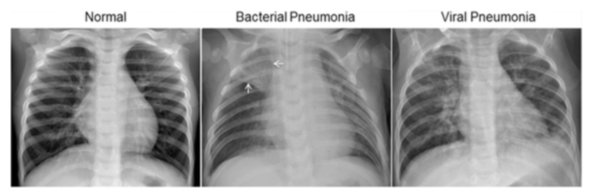

The data found in the `NORMAL` folders were compiled together and the images in the `PNEUMONIA` folders were compiled together separately. These were then split into training and testing data using the python library [`python_splitter`](https://github.com/bharatadk/python_splitter). A compressed version of this cleaned data is available on [Amazon S3](https://flatiron-phase4-xray.s3.amazonaws.com/Train_Test_Folder.zip)


In [1]:
# Unpack the data.zip from Kaggle and turn into test-train split using python_splitter
# 80% will be in training, 20% in testing

import os
# absolute path of unzipped data directory
PATH = os.path.join(os.path.abspath(os.getcwd()),'data/')

# Uncomment the lines below to install python_splitter and create the
# trian test split
#!pip install python_splitter
#from python_splitter import split_from_folder # https://github.com/bharatadk/python_splitter
#split_from_folder(PATH, train = 0.8, test=0.2)

In [2]:
# Check for class imbalance between pneumonia and normal classified images
def file_count(path, class_name):
    '''
    This helper function takes a file directory and counts
    the number of files in each subdirectory.
    '''
    import os
    dir_path = os.path.join(path, class_name + '/')
    count = 0
    for root_dir, cur_dir, files in os.walk(dir_path):
        count += len(files)
    print(f'{class_name} file count: {count}')
    return count
    
normal_count = file_count(PATH, 'NORMAL')
pneumonia_count = file_count(PATH, 'PNEUMONIA')
total_count = normal_count + pneumonia_count

normal_weight = total_count / (2*normal_count)
pneumonia_weight = total_count / (2*pneumonia_count)

print(f'NORMAL weight: {normal_weight}')
print(f'PNEUMONIA weight: {pneumonia_weight}')

NORMAL file count: 1583
PNEUMONIA file count: 4273
NORMAL weight: 1.8496525584333543
PNEUMONIA weight: 0.6852328574771823


### Class Imbalance

The data consists of chest x-ray images of those that have pneumonia and those that do not (normal).
There is a total of 5,856 images of which 27% are in the normal class and 73% are in the pneumonia
class. This data is imbalanced and a model would be more exposed to images classified as pneumonia. This could lead to the model classifing every image in this dataset as having pneumonia and it would be 73% accurate.

I can set the class weights attribute in keras to give more wieghts to the underrepresented class. Class weights are inversely proportional to their respective frequencies. The formula to calculate the class weights is:

$$w_j = \frac{n_{samples}}{n_{classes} \times n_{samples}}$$

The weight attribute will tell the model to pay more attention to samples from the under-represented class, normal.

In [4]:
# Set directories for the train-test data
import os, shutil

data_path = os.path.join(os.path.abspath(os.getcwd()),'Train_Test_Folder/')
train_dir = os.path.join(data_path, 'train/')
test_dir = os.path.join(data_path, 'test/')
train_normal = os.path.join(train_dir, 'NORMAL/')
train_pneumonia = os.path.join(train_dir, 'PNEUMONIA/')

Image number: 1266
normal picture title:  NORMAL2-IM-0665-0001.jpeg
pneumonia picture title: person106_virus_194.jpeg


Text(0.5, 1.0, 'Pneumonia')

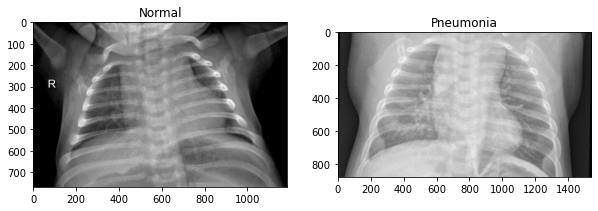

In [5]:
# Show a representative image of the data
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

print(f'Image number: {len(os.listdir(train_normal))}')
rand_norm = np.random.randint(0, len(os.listdir(train_normal)))
norm_img = os.listdir(train_normal)[rand_norm]
print('normal picture title: ', norm_img)
norm_img_address = train_normal+norm_img

#Pneumonia
rand_p = np.random.randint(0,len(os.listdir(train_pneumonia)))

pneu_img =  os.listdir(train_pneumonia)[rand_norm]
pneu_img_address = train_pneumonia+pneu_img
print('pneumonia picture title:', pneu_img)

# Load the image
norm_load = Image.open(norm_img_address)
pneu_load = Image.open(pneu_img_address)

# Show the picture
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load, cmap='gray')
ax1.set_title('Normal')

ax2 = fig.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneu_load, cmap='gray')
ax2.set_title('Pneumonia')

In [6]:
# Import data into tensorflow Dataset object
from tensorflow.keras.utils import image_dataset_from_directory

img_height = 128
img_width = 128
grayscale = 1
batch_size = 64

train_ds, val_ds = image_dataset_from_directory(train_dir,
                                        color_mode='grayscale',
                                        label_mode='binary',
                                        validation_split=0.2,
                                        subset='both',
                                        seed=42,
                                        #shuffle=False,
                                        image_size=(img_height, img_width),
                                        batch_size = batch_size)


test_ds = image_dataset_from_directory(test_dir,
                                       shuffle=False,
                                       color_mode='grayscale',
                                       label_mode='binary',
                                       image_size=(img_height, img_width)
                                      )

# print out the number of batches and data type
print('Batches for testing -->', test_ds.cardinality())
print('Batches for validating -->', val_ds.cardinality())
print('Batches for training -->', train_ds.cardinality())

2022-12-13 14:27:42.972693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 4684 files belonging to 2 classes.
Using 3748 files for training.
Using 936 files for validation.
Found 1172 files belonging to 2 classes.
Batches for testing --> tf.Tensor(37, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(15, shape=(), dtype=int64)
Batches for training --> tf.Tensor(59, shape=(), dtype=int64)


In [7]:
# Display tensor shape of data in tensorflow object
print(train_ds.class_names)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

['NORMAL', 'PNEUMONIA']
(64, 128, 128, 1)
(64, 1)


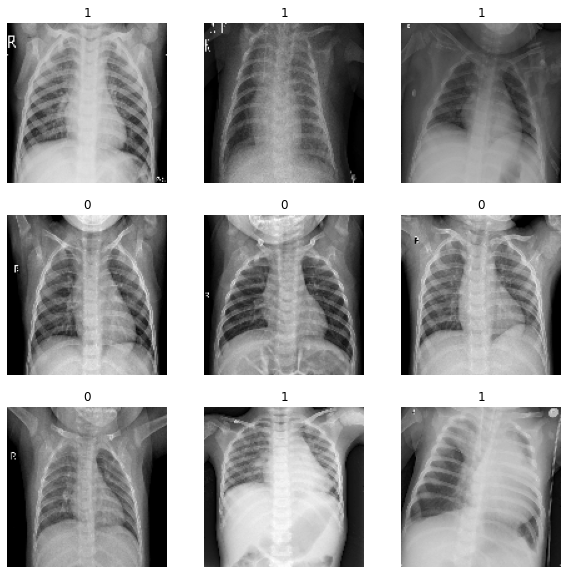

In [8]:
# Visualize the data stored in the tensorflow object
# 0 = normal
# 1 = pneumonia
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'), cmap='gray')
        plt.title(int(labels[i]))
        plt.axis('off')

In [9]:
# Configure the dataset for performance
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE

# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. 
# This will ensure the dataset does not become a bottleneck while training the model.
# Dataset.prefetch overlaps data preprocessing and model execution while training.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Modeling
Convolutional Neural Networks (CNN) is a machine learning technique that reduces the high dimensionality of images without losing its information. CNNs have outperformed other machine learning algorithms in image classification.

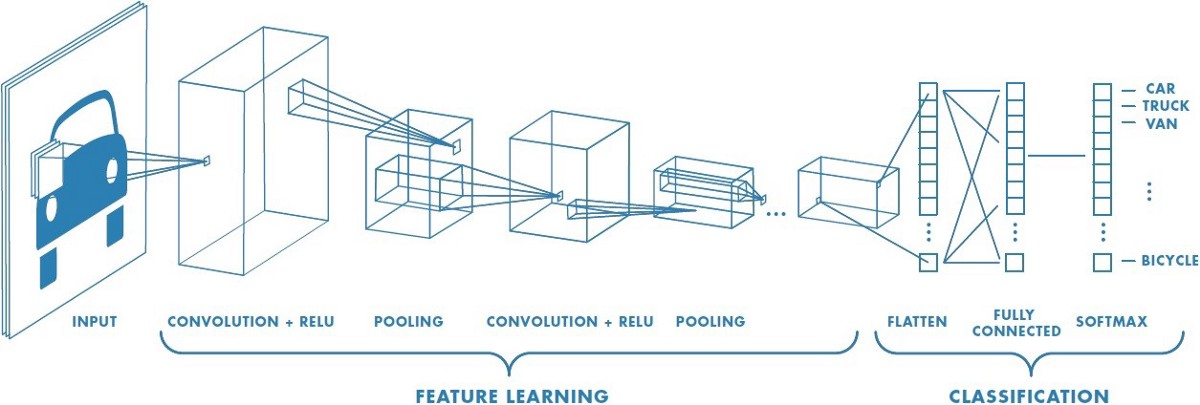

While densly connected neural networks learn global patterns in ther input feature space, convolution layers learn local paterns, that are found in 2-dimensional windows. This allows CNNs to learn patterns that are translation-invariant, something learned in one part of the image can be reused in another part. CNNs can also learn spatial heirarchies of patterns. The first layer of a CNN learns small local patterns such as edges. The next layer will learn larger patterns.

![CNN spatial hierarchies](img/spatial_hierarchy.PNG)

In [10]:
# libraries for neural networks
#from tensorflow import keras
from tensorflow.keras.models import Sequential
import keras
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Rescaling
from keras.layers import BatchNormalization
from keras.metrics import SpecificityAtSensitivity

In [11]:
def plot_fun(model, epochs):
    '''
    Plotting helper function.
    Plots the Training and validation accuracy
    as well as the training and validation loss
    over the number of epochs specified
    '''
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'g-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'g-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [30]:
def confusion_matrix_plot(ds, model):
    # https://stackoverflow.com/a/66872173/1144724

    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    
    ds_list = list(ds)
    features = np.concatenate([ds_list[n][0] for n in range(0, len(ds_list))])
    true_id = np.concatenate([ds_list[n][1] for n in range(0, len(ds_list))])
    
    # Create pedictions
    predicted_id = model.predict(features)
    predicted_id[predicted_id > 0.5] = 1 # prediction less than 0.5 are normal (0)
    predicted_id[predicted_id < 0.5] = 0 # predictions greater than 0.5 are pneumonia (1)

    cm = confusion_matrix(true_id, predicted_id)
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(1,1,1)
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(cm, annot=True, annot_kws={"size": 12},
         cbar = False, cmap='Greens', fmt='g');
    ax1.set_ylabel('True Values',fontsize=14)
    ax1.set_xlabel('Predicted Values',fontsize=14)
    plt.grid(False)
    plt.show()

## Model 1: Baseline model
This model implements a simple CNN. It rescales the the pixel data to be between 0 and 1. It has a single CNN layer and after downsizes the output through a max pooling layer. That is then flattened and put into a dense layer with one output. This output is a prediction of whether the image is classified as pneumonia (1) or normal (0).

In [15]:
#import tensorflow.keras import layers

batch_size = 64
learning_rate = 5e-4 #1e-3 #3e-4
epochs = 30

# Baseline model
inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)
model_baseline = keras.Model(inputs=inputs, outputs=outputs)

# Compile the Neural network
model_baseline.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.9),
                                   keras.metrics.SensitivityAtSpecificity(0.9)])

# Summary
model_baseline.summary()

# Save model at best point
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/baseline_model.keras',
        save_best_only=True,
        monitor='val_loss')
        ]

# Fit model
class_weights = {0: normal_weight,
                1: pneumonia_weight}

model_baseline_fit = model_baseline.fit(train_ds,
                                         epochs=epochs,
                                         validation_data = val_ds,
                                         batch_size=batch_size,
                                         callbacks=callbacks,
                                         class_weight=class_weights)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 127008)            0         
                                                                 
 dense_2 (Dense)             (None, 1)                 127009    
                                                           

Epoch 21/30
59/59 [==============================] - 10s 175ms/step - loss: 0.0764 - accuracy: 0.9731 - recall_2: 0.9714 - specificity_at_sensitivity_2: 1.0000 - sensitivity_at_specificity_2: 0.9945 - val_loss: 0.1874 - val_accuracy: 0.9306 - val_recall_2: 0.9130 - val_specificity_at_sensitivity_2: 1.0000 - val_sensitivity_at_specificity_2: 0.9783
Epoch 22/30
59/59 [==============================] - 9s 160ms/step - loss: 0.0779 - accuracy: 0.9739 - recall_2: 0.9718 - specificity_at_sensitivity_2: 1.0000 - sensitivity_at_specificity_2: 0.9967 - val_loss: 0.1082 - val_accuracy: 0.9626 - val_recall_2: 0.9739 - val_specificity_at_sensitivity_2: 1.0000 - val_sensitivity_at_specificity_2: 0.9768
Epoch 23/30
59/59 [==============================] - 9s 158ms/step - loss: 0.0763 - accuracy: 0.9717 - recall_2: 0.9685 - specificity_at_sensitivity_2: 1.0000 - sensitivity_at_specificity_2: 0.9941 - val_loss: 0.1259 - val_accuracy: 0.9487 - val_recall_2: 0.9464 - val_specificity_at_sensitivity_2: 1.

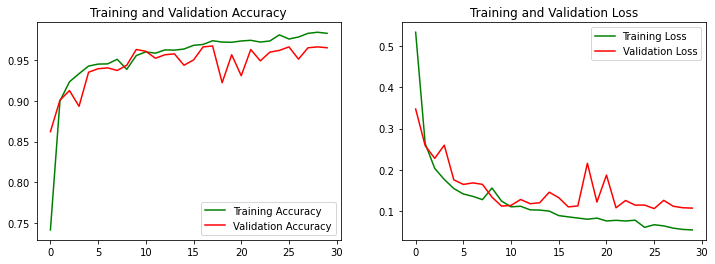

In [17]:
plot_fun(model_baseline_fit, epochs)

118/118 [==============================] - 2s 20ms/step


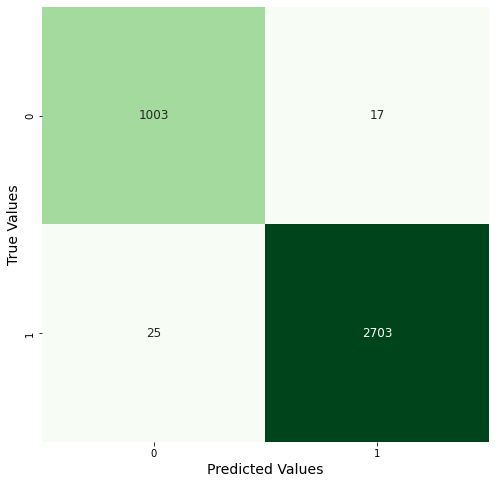

In [19]:
confusion_matrix_plot(val_ds, model_baseline)

### Discussion of model 1

The training accuracy is increasing lineary while the training loss decreases. Around epoch 10 the validation accuracy and loss start to diverge. This is characteristic of  a model that is overfitting. After epoch 10 the model is overfitting but before epoch 10 the model is underfitting. At epoch 10 the validation accuracy is 96%, recall is  97%, specificity of 99.6%, and sensitivity of 98%.

#### Needs to be updated becuse use the validation data for the confusion matrix
The confusion matrix identifies that there are 25 images out of 3748 that were classified as normal when they actually had pneumonia. This is about 0.7% or a 99.3% specificity. This is a very important metric to evaluate for this model because we do not want many patients to be classified as not having pneumonia when they actually do according to the chest x-ray. These individuals' chest x-ray would not be evaluated by a radiologist in our medical imaging pipeline.

## Model 2
The baseline model is extremely good and beats our required metric of 90% for accuracy and 95% for specificity. It is always good to compare other models in case they perform better. The second model increases the number of layers in the CNN from one to three.

In [21]:
# Model 2
inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2, padding='same')(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2, padding='same')(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2, padding='same')(x)
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)

# Compile the Neural network
model2.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.9),
                                   keras.metrics.SensitivityAtSpecificity(0.9)])

# Summary
model2.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/model2.keras',
        save_best_only=True,
        monitor='val_loss')
]

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                       

In [26]:
# Fit model
epochs=30
model2_fit = model2.fit(train_ds,
                        steps_per_epoch=len(train_ds),
                        epochs=epochs,
                        validation_data = val_ds,
                        batch_size=batch_size,
                        callbacks=callbacks,
                        class_weight=class_weights,
                        verbose=1)

Epoch 1/30
59/59 [==============================] - 39s 663ms/step - loss: 0.0610 - accuracy: 0.9779 - recall_4: 0.9769 - specificity_at_sensitivity_4: 0.9990 - sensitivity_at_specificity_3: 0.9930 - val_loss: 0.1095 - val_accuracy: 0.9583 - val_recall_4: 0.9783 - val_specificity_at_sensitivity_4: 0.9756 - val_sensitivity_at_specificity_3: 0.9812
Epoch 2/30
59/59 [==============================] - 37s 620ms/step - loss: 0.0512 - accuracy: 0.9824 - recall_4: 0.9791 - specificity_at_sensitivity_4: 0.9990 - sensitivity_at_specificity_3: 0.9960 - val_loss: 0.1340 - val_accuracy: 0.9455 - val_recall_4: 0.9420 - val_specificity_at_sensitivity_4: 0.9878 - val_sensitivity_at_specificity_3: 0.9841
Epoch 3/30
59/59 [==============================] - 37s 622ms/step - loss: 0.0462 - accuracy: 0.9832 - recall_4: 0.9824 - specificity_at_sensitivity_4: 1.0000 - sensitivity_at_specificity_3: 0.9956 - val_loss: 0.1187 - val_accuracy: 0.9615 - val_recall_4: 0.9652 - val_specificity_at_sensitivity_4: 0.9

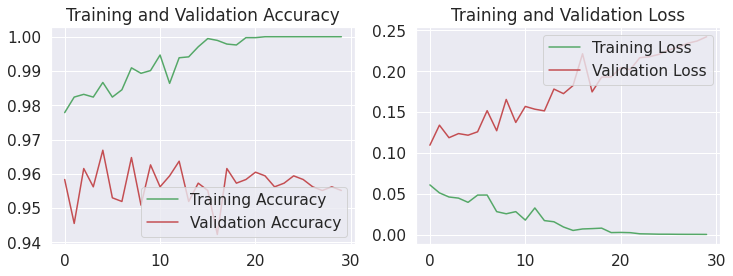

In [28]:
plot_fun(model2_fit, epochs)

30/30 [==============================] - 3s 100ms/step


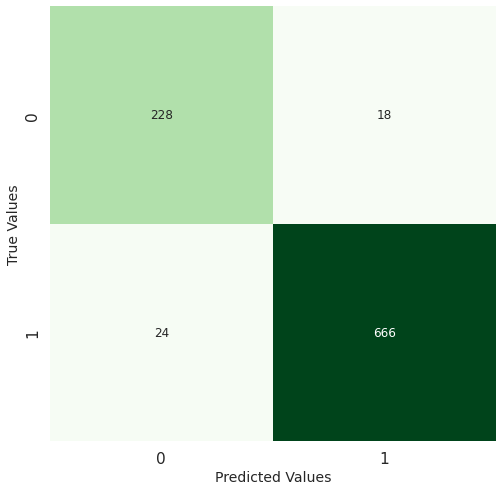

In [32]:
confusion_matrix_plot(val_ds, model2)

## Discussion
The training and validation accuracy and loss do not converge in this neural network and is immediatly overfitting. This may be because we do not have many testing samles to learn from so the model is overfitting very quickly. We can reduce overfitting by adding a dropout layer. This will randomly select which neurons to keep for the model. The next goal is to maximize generalization performance. I will use a dropout layer to regularize.

In [34]:
# Model 3
# Include a dropout
from keras.layers import Dropout

#learning_rate = 0.001
#batch_size=32

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)

# Compile the Neural network
model3.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.9),
                                   keras.metrics.SensitivityAtSpecificity(0.9)])

# Summary
model3.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/model3.keras',
        save_best_only=True,
        monitor='val_loss')
]

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                      

Epoch 1/40
59/59 [==============================] - 31s 512ms/step - loss: 0.4784 - accuracy: 0.7543 - recall_6: 0.7291 - specificity_at_sensitivity_6: 0.5971 - sensitivity_at_specificity_4: 0.6129 - val_loss: 0.3981 - val_accuracy: 0.8109 - val_recall_6: 0.7522 - val_specificity_at_sensitivity_6: 0.8984 - val_sensitivity_at_specificity_4: 0.8913
Epoch 2/40
59/59 [==============================] - 28s 475ms/step - loss: 0.2331 - accuracy: 0.9104 - recall_6: 0.9109 - specificity_at_sensitivity_6: 0.9098 - sensitivity_at_specificity_4: 0.9205 - val_loss: 0.1994 - val_accuracy: 0.9209 - val_recall_6: 0.9072 - val_specificity_at_sensitivity_6: 0.9593 - val_sensitivity_at_specificity_4: 0.9594
Epoch 3/40
59/59 [==============================] - 30s 505ms/step - loss: 0.1839 - accuracy: 0.9293 - recall_6: 0.9300 - specificity_at_sensitivity_6: 0.9500 - sensitivity_at_specificity_4: 0.9538 - val_loss: 0.1599 - val_accuracy: 0.9402 - val_recall_6: 0.9290 - val_specificity_at_sensitivity_6: 0.9

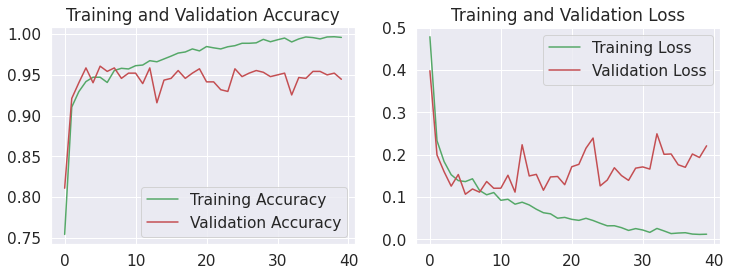

In [35]:
# Fit model
epochs=40
model3_fit = model3.fit(train_ds,
                        #steps_per_epoch=len(train_ds),
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         class_weight=class_weights,
                         verbose=1)

plot_fun(model3_fit, epochs)

30/30 [==============================] - 2s 62ms/step


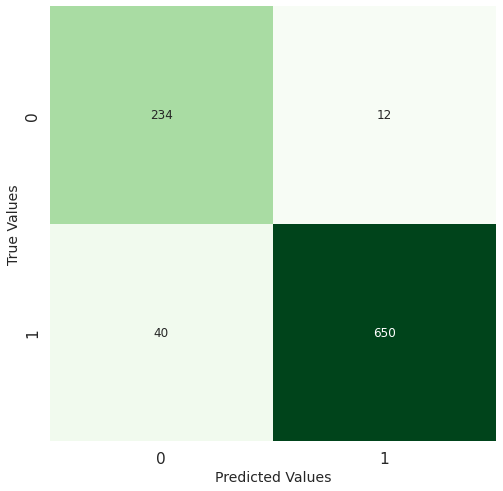

In [36]:
confusion_matrix_plot(val_ds, model3)

## Model 3 discussion
Including a dropout layer reduces the quick overfitting found in model 2 and is more similar to the baseline model. The confusion matrix identifies that there are 40 images out of 936 that were classified as normal when they actually had pneumonia. This is worse than the baseline model which had ....

At epoch 8 the training and validation accuracy and loss start to diverge. At epoch 8 the validation accuracy is 96%, recall is 96%, specificity is 99%, and sensitivity is 98%. This is very similar to the baseline model. 

To make sure we are avoiding overfitting we can use data augmentation to slightly modify the images we currently have by rotating them, flipping them, and zooming into them to create many more images.

## Model 4: CNN with data augmentation


In [47]:
# Model 4: Data augmentationl

#learning_rate = 0.0005

from keras import layers

data_augmentation = Sequential(
        [
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ])

from keras.layers import Dropout

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = data_augmentation(inputs)
x = Rescaling(1./255)(x)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dense(128, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model4 = keras.Model(inputs=inputs, outputs=outputs)

# Compile the Neural network
model4.compile(optimizer = keras.optimizers.Adam(learning_rate), 
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy', 
                                   keras.metrics.Recall(),
                                   keras.metrics.SpecificityAtSensitivity(0.9),
                                   keras.metrics.SensitivityAtSpecificity(0.9)])

# Summary
model4.summary()

# Save only the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/model4.keras',
        save_best_only=True,
        monitor='val_loss')
]

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 1)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 64)        18496     
                                                           

In [49]:
# Fit model
epochs=30
#batch_size = 8
model4_fit = model4.fit(train_ds,
                        steps_per_epoch=len(train_ds),
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callbacks=callbacks,
                         class_weight=class_weights)

Epoch 1/30
59/59 [==============================] - 43s 739ms/step - loss: 0.6478 - accuracy: 0.5888 - recall_8: 0.5396 - specificity_at_sensitivity_8: 0.2118 - sensitivity_at_specificity_5: 0.3105 - val_loss: 0.8204 - val_accuracy: 0.4006 - val_recall_8: 0.1884 - val_specificity_at_sensitivity_8: 0.6626 - val_sensitivity_at_specificity_5: 0.7188
Epoch 2/30
59/59 [==============================] - 43s 729ms/step - loss: 0.4712 - accuracy: 0.7705 - recall_8: 0.7617 - specificity_at_sensitivity_8: 0.6059 - sensitivity_at_specificity_5: 0.5510 - val_loss: 0.3802 - val_accuracy: 0.8611 - val_recall_8: 0.8493 - val_specificity_at_sensitivity_8: 0.7927 - val_sensitivity_at_specificity_5: 0.8304
Epoch 3/30
59/59 [==============================] - 42s 722ms/step - loss: 0.3835 - accuracy: 0.8146 - recall_8: 0.8057 - specificity_at_sensitivity_8: 0.7127 - sensitivity_at_specificity_5: 0.7313 - val_loss: 0.3504 - val_accuracy: 0.8622 - val_recall_8: 0.8406 - val_specificity_at_sensitivity_8: 0.8

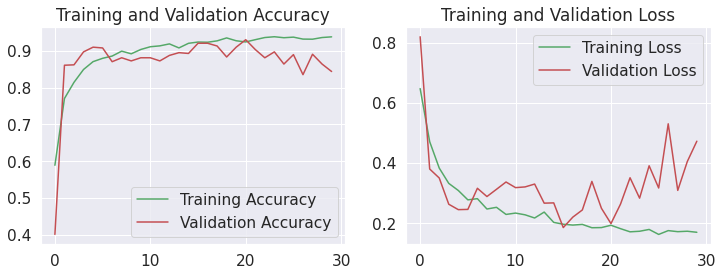

30/30 [==============================] - 3s 103ms/step


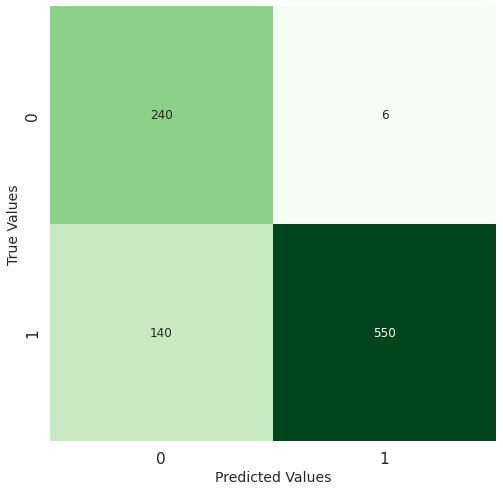

In [50]:
plot_fun(model4_fit, epochs)
confusion_matrix_plot(val_ds, model4)

### Discussion

Model 4 uses data augmentaiton to increase the number of training data to fit the model to. As shown in the confusion matrix for the training data ...

When evaluating the validation or testing data, the data is not augmented. This is shown with the validation confusion matrix as it has the same number of samples as the other models. Model 4 has a higher number of false negatives than the previous models but this may because it is not overfitting as much as the other models. ????? Model 4 has very small amount of false positivies.

The model diverges at epoch 20 in model 4. 

## Model 5

To increase the effectiveness of the CNN to classify the x-ray data we can use pretrained network to help. 

What is a pretrained network?



In [39]:
# Model with transfer learning
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(img_height, img_width, 3))

conv_base.trainable = False

conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [40]:
# Model 5
# With a pretrained model

#learning_rate = 0.00005

inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = data_augmentation(inputs)
x = Conv2D(3,(3,3), padding='same')(x)
x = keras.applications.vgg19.preprocess_input(x)
x = conv_base(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model5 = keras.Model(inputs, outputs)

# Compile
model5.compile(loss='binary_crossentropy',
               optimizer=keras.optimizers.Adam(learning_rate),
               metrics = ['accuracy', 
                           keras.metrics.Recall(),
                           keras.metrics.SpecificityAtSensitivity(0.9),
                           keras.metrics.SensitivityAtSpecificity(0.9)])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/m5_feature_extraction_with_data_augmentation.keras',
        save_best_only=True,
        monitor='val_loss')
]

Epoch 1/30


59/59 [==============================] - 474s 8s/step - loss: 4.0839 - accuracy: 0.8605 - val_loss: 2.1610 - val_accuracy: 0.9274
Epoch 2/30
59/59 [==============================] - 472s 8s/step - loss: 2.1958 - accuracy: 0.9066 - val_loss: 1.6040 - val_accuracy: 0.9274
Epoch 3/30
59/59 [==============================] - 474s 8s/step - loss: 1.9757 - accuracy: 0.9130 - val_loss: 1.6582 - val_accuracy: 0.9316
Epoch 4/30
59/59 [==============================] - 472s 8s/step - loss: 1.8424 - accuracy: 0.9200 - val_loss: 2.3442 - val_accuracy: 0.8996
Epoch 5/30
59/59 [==============================] - 460s 8s/step - loss: 1.9105 - accuracy: 0.9152 - val_loss: 2.0645 - val_accuracy: 0.9252
Epoch 6/30
59/59 [==============================] - 468s 8s/step - loss: 1.3770 - accuracy: 0.9282 - val_loss: 2.1269 - val_accuracy: 0.9188
Epoch 7/30
59/59 [==============================] - 477s 8s/step - loss: 1.3059 - accuracy: 0.9253 - val_loss: 1.1678 - val_accuracy: 0.9434
Epoch 8/30
59/59 [======

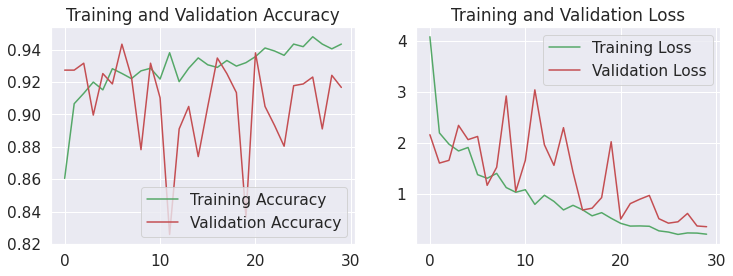

30/30 [==============================] - 47s 2s/step


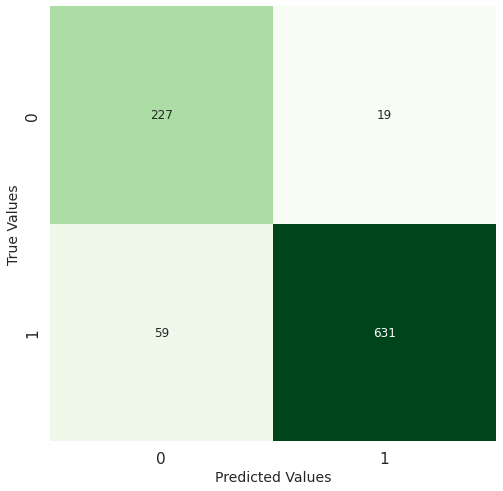

In [41]:
#batch_size = 32
epochs = 30
model5_fit = model5.fit(train_ds,
                         #steps_per_epoch=10,
                         epochs=epochs,
                         validation_data = val_ds,
                         batch_size=batch_size,
                         callbacks=callbacks)
plot_fun(model5_fit, epochs)
confusion_matrix_plot(val_ds, model5)

### Discussion



In [42]:
# Model 6: Unfreeze more layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False
    
inputs = keras.Input(shape=(img_height, img_width, grayscale))
x = data_augmentation(inputs)
x = Conv2D(3,(3,3), padding='same')(x)
x = keras.applications.vgg19.preprocess_input(x)
x = conv_base(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model6 = keras.Model(inputs, outputs)

# Compile
model6.compile(loss='binary_crossentropy',
               optimizer=keras.optimizers.Adam(learning_rate),
               metrics = ['accuracy', 
                           keras.metrics.Recall(),
                           keras.metrics.SpecificityAtSensitivity(0.9),
                           keras.metrics.SensitivityAtSpecificity(0.9)])
    
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/keras/m6_pretrained_cnn_top4unfrozen.keras',
        save_best_only=True,
        monitor='val_loss')
]

epochs = 30

model6_fit = model5.fit(train_ds,
                        epochs = epochs,
                        validation_data=val_ds,
                        callbacks=callbacks)


Epoch 1/30
59/59 [==============================] - 490s 8s/step - loss: 0.1850 - accuracy: 0.9453 - val_loss: 0.2837 - val_accuracy: 0.9284
Epoch 2/30
59/59 [==============================] - 494s 8s/step - loss: 0.1578 - accuracy: 0.9506 - val_loss: 0.3074 - val_accuracy: 0.9209
Epoch 3/30
59/59 [==============================] - 498s 8s/step - loss: 0.1407 - accuracy: 0.9530 - val_loss: 0.2335 - val_accuracy: 0.9359
Epoch 4/30
59/59 [==============================] - 499s 8s/step - loss: 0.1619 - accuracy: 0.9488 - val_loss: 0.2744 - val_accuracy: 0.9220
Epoch 5/30
59/59 [==============================] - 500s 8s/step - loss: 0.1396 - accuracy: 0.9509 - val_loss: 0.3694 - val_accuracy: 0.8996
Epoch 6/30
59/59 [==============================] - 500s 8s/step - loss: 0.1522 - accuracy: 0.9464 - val_loss: 0.2617 - val_accuracy: 0.9231
Epoch 7/30
59/59 [==============================] - 496s 8s/step - loss: 0.1320 - accuracy: 0.9525 - val_loss: 0.2015 - val_accuracy: 0.9391
Epoch 8/30
59

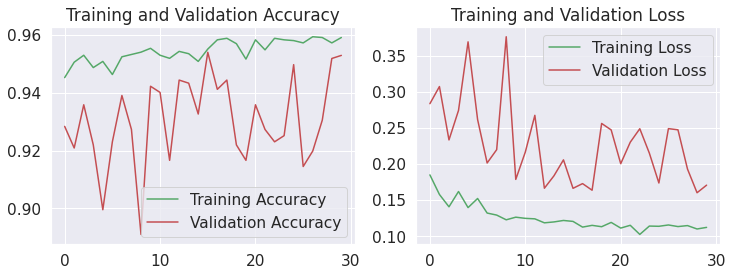

30/30 [==============================] - 49s 2s/step


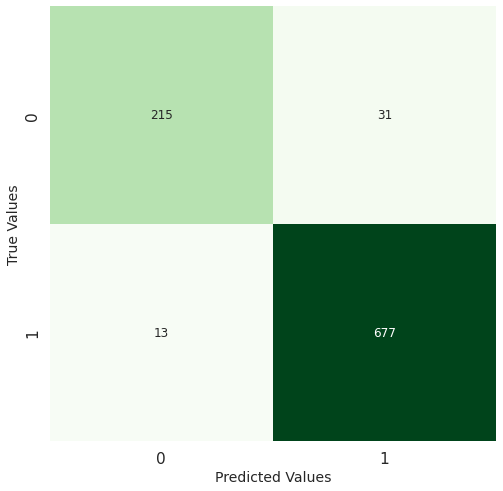

In [44]:
plot_fun(model6_fit, epochs)
confusion_matrix_plot(val_ds, model5)

In [53]:
# Analyze models on test data

def model_evaluate(best_model, test_data):
    model = keras.models.load_model(best_model)
    test_loss, test_accuracy, test_recall, test_specificity, test_sensitivity = model.evaluate(test_data)
    print(f'Test accuracy of {best_model}: {test_accuracy:.3f}')

model_evaluate('models/keras/baseline_model.keras', test_ds)
model_evaluate('models/keras/model2.keras', test_ds)
model_evaluate('models/keras/model3.keras', test_ds)
model_evaluate('models/keras/model4.keras', test_ds)


37/37 [==============================] - 1s 17ms/step - loss: 0.1225 - accuracy: 0.9565 - recall_2: 0.9708 - specificity_at_sensitivity_2: 0.9937 - sensitivity_at_specificity_2: 0.9766
Test accuracy of models/keras/baseline_model.keras: 0.956
37/37 [==============================] - 4s 108ms/step - loss: 0.1228 - accuracy: 0.9565 - recall_4: 0.9661 - specificity_at_sensitivity_4: 0.9874 - sensitivity_at_specificity_3: 0.9778
Test accuracy of models/keras/model2.keras: 0.956
37/37 [==============================] - 2s 62ms/step - loss: 0.1239 - accuracy: 0.9548 - recall_6: 0.9789 - specificity_at_sensitivity_6: 0.9811 - sensitivity_at_specificity_4: 0.9778
Test accuracy of models/keras/model3.keras: 0.955
37/37 [==============================] - 3s 86ms/step - loss: 0.1802 - accuracy: 0.9292 - recall_8: 0.9333 - specificity_at_sensitivity_8: 0.9464 - sensitivity_at_specificity_5: 0.9509
Test accuracy of models/keras/model4.keras: 0.929


In [54]:
def model_evaluate(best_model, test_data):
    model = keras.models.load_model(best_model)
    test_loss, test_accuracy = model.evaluate(test_data)
    print(f'Test accuracy of {best_model}: {test_accuracy:.3f}')

model_evaluate('models/keras/m5_feature_extraction_with_data_augmentation.keras', test_ds)
model_evaluate('models/keras/m6_pretrained_cnn_top4unfrozen.keras', test_ds)

37/37 [==============================] - 62s 2s/step - loss: 0.3400 - accuracy: 0.9292
Test accuracy of models/keras/m5_feature_extraction_with_data_augmentation.keras: 0.929
37/37 [==============================] - 65s 2s/step - loss: 0.1710 - accuracy: 0.9505
Test accuracy of models/keras/m6_pretrained_cnn_top4unfrozen.keras: 0.951


37/37 [==============================] - 1s 19ms/step


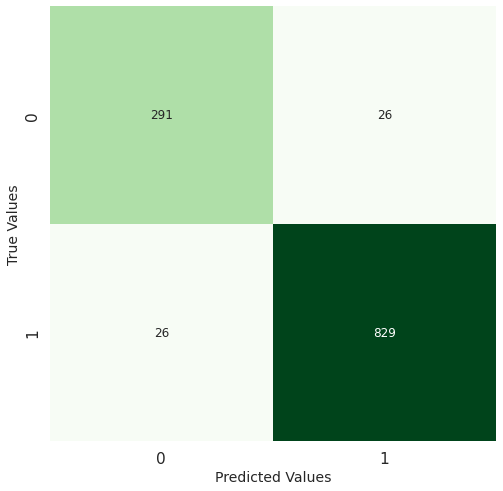

37/37 [==============================] - 3s 89ms/step


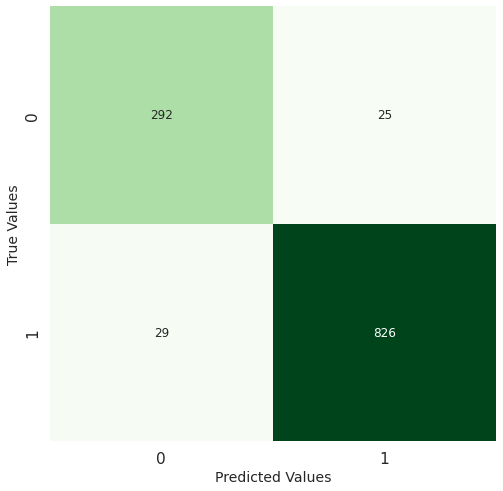

37/37 [==============================] - 2s 59ms/step


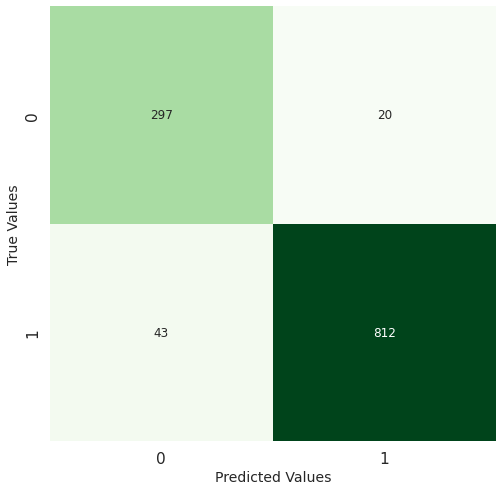

37/37 [==============================] - 3s 95ms/step


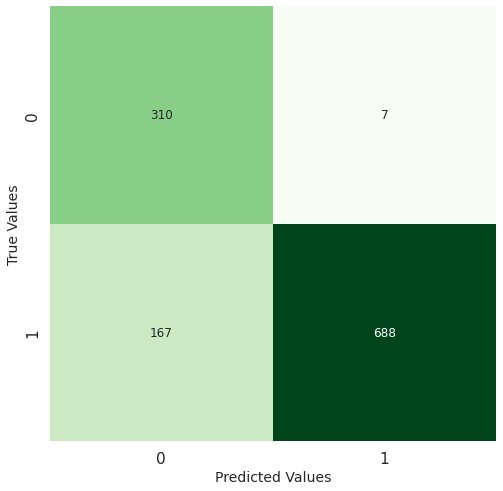

37/37 [==============================] - 62s 2s/step


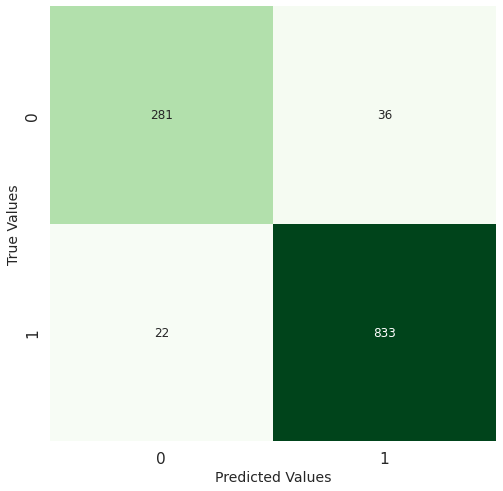

In [56]:
confusion_matrix_plot(test_ds, model_baseline)
confusion_matrix_plot(test_ds, model2)
confusion_matrix_plot(test_ds, model3)
confusion_matrix_plot(test_ds, model4)
confusion_matrix_plot(test_ds, model5)

In [69]:
# save the best model
# Need to fix this

model_best = model
model_file_path = f"huroku_model/xray_pneumonia_classifier/1/"
model_best.save(filepath=model_file_path, save_format='tf')

INFO:tensorflow:Assets written to: huroku_model/xray_pneumonia_classifier/1671127976/assets


INFO:tensorflow:Assets written to: huroku_model/xray_pneumonia_classifier/1671127976/assets


In [74]:
# Zip the file and save to a publically available S3 bucket
import tarfile
import os

def tar_folder(output_filename: str, source_dir: str):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
        
OUT_FILE = "huroku_models.tar.gz"

SOURCE_FILE = "huroku_model"

tar_folder(output_filename=OUT_FILE, source_dir=SOURCE_FILE)



In [ ]:
def predict_pneumonia(img_source, model):
    from tensorflow.keras.utils import load_img, img_to_array
    from tensorflow import keras
    import numpy as np
    
    # Load the model from the file
    model = keras.models.load_model(model)
    
    # Load the image
    img = load_img(img_source,
                   color_mode='grayscale',
                   target_size=(128,128))
    
    # Construct the tensor that .predict is expecting
    #img = load_img(img_source, target_size=(64, 64))
    img = img_to_array(img)
    data = np.expand_dims(img, axis=0)#/255
    #print(data)
    
    # get the prediction and return
    prediction = model.predict(data, verbose=0)
    print(prediction)
    return prediction # return position of the highest probability

In [32]:
# Test Prediction
# Baseline Model
model_src = 'models/keras/baseline_model.keras'

predict_pneumonia('app_img.jpeg', model_src) # normal x-ray from web
predict_pneumonia('app_img_pneumonia.jpg', model_src) # pneumonia image from web
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src) # trained data
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src) # train data
predict_pneumonia('apple.jpeg', model_src) # image of apple

[[0.9050606]]
[[0.6326381]]
[[0.99496114]]
[[0.01159103]]
[[0.96893466]]


array([[0.96893466]], dtype=float32)

In [33]:
# Test Prediction
# Model 2
model_src = 'models/keras/model2.keras'

predict_pneumonia('app_img.jpeg', model_src) # normal x-ray from web
predict_pneumonia('app_img_pneumonia.jpg', model_src) # pneumonia image from web
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src) # trained data
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src) # train data
predict_pneumonia('apple.jpeg', model_src) # image of apple

[[0.92591155]]
[[0.9689954]]
[[0.9994924]]
[[0.00056803]]
[[0.9991294]]


array([[0.9991294]], dtype=float32)

In [34]:
# Test Prediction
# Baseline Model
model_src = 'models/keras/model3.keras'

predict_pneumonia('app_img.jpeg', model_src) # normal x-ray from web
predict_pneumonia('app_img_pneumonia.jpg', model_src) # pneumonia image from web
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src) # trained data
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src) # train data
predict_pneumonia('apple.jpeg', model_src) # image of apple

[[0.92888904]]
[[0.9583747]]
[[0.9933203]]
[[0.01886974]]
[[0.9983168]]


array([[0.9983168]], dtype=float32)

In [35]:
# Test Prediction
# Baseline Model
model_src = 'models/keras/model4.keras'

predict_pneumonia('app_img.jpeg', model_src) # normal x-ray from web
predict_pneumonia('app_img_pneumonia.jpg', model_src) # pneumonia image from web
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src) # trained data
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src) # train data
predict_pneumonia('apple.jpeg', model_src) # image of apple

[[0.12507302]]
[[0.00581573]]
[[0.9935247]]
[[0.00908339]]
[[0.0023333]]


array([[0.0023333]], dtype=float32)

In [36]:
# Test Prediction
# Model 5
model_src = 'models/keras/m5_feature_extraction_with_data_augmentation.keras'

predict_pneumonia('app_img.jpeg', model_src) # normal x-ray from web
predict_pneumonia('app_img_pneumonia.jpg', model_src) # pneumonia image from web
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src) # trained data
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src) # train data
predict_pneumonia('apple.jpeg', model_src) # image of apple

[[8.213028e-09]]
[[0.00030403]]
[[0.9849094]]
[[7.86741e-15]]
[[1.]]


array([[1.]], dtype=float32)

In [31]:
# Test prediction with two best models
# Model 6: Pretrained CNN with top 4 layers unfrozen
model_src = 'models/keras/m6_pretrained_cnn_top4unfrozen.keras'

predict_pneumonia('app_img.jpeg', model_src)
predict_pneumonia('app_img_pneumonia.jpg', model_src)
predict_pneumonia('data/PNEUMONIA/person1_bacteria_1.jpeg', model_src)
predict_pneumonia('data/NORMAL/IM-0001-0001.jpeg', model_src)
predict_pneumonia('apple.jpeg', model_src)

[[3.831872e-05]]
[[0.0053053]]
[[0.99530417]]
[[3.0068363e-09]]
[[0.9999927]]


array([[0.9999927]], dtype=float32)

## Prediction Function discussion
The best model from the output of the prediction function would be model 4. It is able to distinguish images with and without pneumonia and also images that are not X-rays as not having pneumonia. The baseline model and model 2 are classifies all the test images as having pneumonia except the normal X-ray in the training data. This includes classifing the image of the apple as having pneumonia. Model 5 and 6 are capable of distinguishing normal and pneumonia X-rays from each other, including the images found on the web, but they also classify the image of the apple as having pneumonia.

Deploying a model that classifies images such as an apple as having pneumonia would greatly reduce confidence in the pneumonia prediction tool. 